In [1]:
from GraphTsetlinMachine.graphs import Graphs
import numpy as np
from scipy.sparse import csr_matrix
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from time import time
import argparse
from skimage.util import view_as_windows
from numba import jit
from keras.datasets import cifar10
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-04-27 20:21:45.338720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 20:21:45.351018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745785305.364407  319771 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745785305.368250  319771 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745785305.379251  319771 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
def default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=50, type=int)
    parser.add_argument("--number-of-clauses", default=40000, type=int)
    parser.add_argument("--T", default=7500, type=int)
    parser.add_argument("--s", default=20.0, type=float)
    parser.add_argument("--number-of-state-bits", default=8, type=int)
    parser.add_argument("--depth", default=1, type=int)
    parser.add_argument("--hypervector-size", default=128, type=int)
    parser.add_argument("--hypervector-bits", default=2, type=int)
    parser.add_argument("--message-size", default=256, type=int)
    parser.add_argument("--message-bits", default=2, type=int)
    parser.add_argument("--patch_size", default=8, type=int)
    parser.add_argument('--double-hashing', dest='double_hashing', default=False, action='store_true')
    parser.add_argument('--one-hot-encoding', dest='one_hot_encoding', default=True, action='store_true')
    parser.add_argument("--max-included-literals", default=32, type=int)

    args = parser.parse_args(args=[])

    for key, value in kwargs.items():
        if key in args.__dict__:
            setattr(args, key, value)
    return args

args = default_args()

In [3]:
def horizontal_flip(image):
    return cv2.flip(image.astype(np.uint8), 1)

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = X_train
Y_train = Y_train

X_test = X_test
Y_test = Y_test

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

for i in range(X_train.shape[0]):
        for j in range(X_train.shape[3]):
                X_train[i,:,:,j] = cv2.adaptiveThreshold(X_train[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

for i in range(X_test.shape[0]):
        for j in range(X_test.shape[3]):
                X_test[i,:,:,j] = cv2.adaptiveThreshold(X_test[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

X_train = X_train.astype(np.uint32)
X_test = X_test.astype(np.uint32)
Y_train = Y_train.astype(np.uint32)
Y_test = Y_test.astype(np.uint32)

In [4]:
dim = 32 - args.patch_size + 1

number_of_nodes = (dim * dim) * 2
print(number_of_nodes)

symbols = []

# Column and row symbols
for i in range(dim):
    symbols.append(f"C:{i}")
    symbols.append(f"R:{i}")

# Patch pixel symbols
for i in range(args.patch_size*args.patch_size*3):
    symbols.append(i)

print(symbols)

1250
['C:0', 'R:0', 'C:1', 'R:1', 'C:2', 'R:2', 'C:3', 'R:3', 'C:4', 'R:4', 'C:5', 'R:5', 'C:6', 'R:6', 'C:7', 'R:7', 'C:8', 'R:8', 'C:9', 'R:9', 'C:10', 'R:10', 'C:11', 'R:11', 'C:12', 'R:12', 'C:13', 'R:13', 'C:14', 'R:14', 'C:15', 'R:15', 'C:16', 'R:16', 'C:17', 'R:17', 'C:18', 'R:18', 'C:19', 'R:19', 'C:20', 'R:20', 'C:21', 'R:21', 'C:22', 'R:22', 'C:23', 'R:23', 'C:24', 'R:24', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,

In [5]:
graphs_train = Graphs(
    X_train.shape[0],
    symbols=symbols,
    hypervector_size=args.hypervector_size,
    hypervector_bits=args.hypervector_bits,
    double_hashing = args.double_hashing,
    one_hot_encoding = args.one_hot_encoding
)

for graph_id in range(X_train.shape[0]):
    graphs_train.set_number_of_graph_nodes(graph_id, number_of_nodes)

graphs_train.prepare_node_configuration()

for graph_id in range(X_train.shape[0]):
    for node_id in range(graphs_train.number_of_graph_nodes[graph_id]):
        graphs_train.add_graph_node(graph_id, node_id, 0)

graphs_train.prepare_edge_configuration()

for graph_id in range(X_train.shape[0]):
    if graph_id % 1000 == 0:
        print(graph_id, X_train.shape[0])

    image = X_train[graph_id, :, :]
    flipped_image = horizontal_flip(image)
     
    windows = view_as_windows(image, (args.patch_size, args.patch_size, 3))
    flipped_windows = view_as_windows(flipped_image, (args.patch_size, args.patch_size, 3))
    for q in range(windows.shape[0]):
            for r in range(windows.shape[1]):
                # Original node
                node_id = (q * dim + r) * 2

                patch = windows[q,r,0]
                flattened_patch = patch.reshape(-1).astype(np.uint32)
                for k in flattened_patch.nonzero()[0]:
                    graphs_train.add_graph_node_property(graph_id, node_id, k)
                for s in range(q + 1):
                    graphs_train.add_graph_node_property(graph_id, node_id, f"C:{s}")
                for s in range(r + 1):
                    graphs_train.add_graph_node_property(graph_id, node_id, f"R:{s}")

                # Flipped node
                node_id_flipped = (q * dim + r) * 2 + 1

                flipped_patch = flipped_windows[q, r, 0]
                flattened_flipped_patch = flipped_patch.reshape(-1).astype(np.uint32)
                for k in flattened_flipped_patch.nonzero()[0]:
                    graphs_train.add_graph_node_property(graph_id, node_id_flipped, k)
                for s in range(q + 1):
                    graphs_train.add_graph_node_property(graph_id, node_id_flipped, f"C:{s}")
                for s in range(r + 1):
                    graphs_train.add_graph_node_property(graph_id, node_id_flipped, f"R:{s}")


graphs_train.encode()

print("Training data produced")

0 50000


1000 50000


2000 50000


3000 50000


4000 50000


5000 50000


6000 50000


7000 50000


8000 50000


9000 50000


10000 50000


11000 50000


12000 50000


13000 50000


14000 50000


15000 50000


16000 50000


17000 50000


18000 50000


19000 50000


20000 50000


21000 50000


22000 50000


23000 50000


24000 50000


25000 50000


26000 50000


27000 50000


28000 50000


29000 50000


30000 50000


31000 50000


32000 50000


33000 50000


34000 50000


35000 50000


36000 50000


37000 50000


38000 50000


39000 50000


40000 50000


41000 50000


42000 50000


43000 50000


44000 50000


45000 50000


46000 50000


47000 50000


48000 50000


49000 50000


Training data produced


In [6]:
graphs_test = Graphs(X_test.shape[0], init_with=graphs_train)
for graph_id in range(X_test.shape[0]):
    graphs_test.set_number_of_graph_nodes(graph_id, number_of_nodes)

graphs_test.prepare_node_configuration()

for graph_id in range(X_test.shape[0]):
    for node_id in range(graphs_test.number_of_graph_nodes[graph_id]):
        graphs_test.add_graph_node(graph_id, node_id, 0)

graphs_test.prepare_edge_configuration()

for graph_id in range(X_test.shape[0]):
    if graph_id % 1000 == 0:
        print(graph_id, X_test.shape[0])
    
    image = X_test[graph_id, :, :]
    flipped_image = horizontal_flip(image)

    windows = view_as_windows(image, (args.patch_size, args.patch_size, 3))
    flipped_windows = view_as_windows(flipped_image, (args.patch_size, args.patch_size, 3))
    for q in range(windows.shape[0]):
            for r in range(windows.shape[1]):
                # Original node
                node_id = (q * dim + r) * 2

                patch = windows[q,r,0]
                flattened_patch = patch.reshape(-1).astype(np.uint32)
                for k in flattened_patch.nonzero()[0]:
                    graphs_test.add_graph_node_property(graph_id, node_id, k)

                for s in range(q+1):
                    graphs_test.add_graph_node_property(graph_id, node_id, f"C:{s}")

                for s in range(r+1):
                    graphs_test.add_graph_node_property(graph_id, node_id, f"R:{s}")

                # Flipped node
                node_id_flipped = (q * dim + r) * 2 + 1

                flipped_patch = flipped_windows[q, r, 0]
                flattened_flipped_patch = flipped_patch.reshape(-1).astype(np.uint32)
                for k in flattened_flipped_patch.nonzero()[0]:
                    graphs_test.add_graph_node_property(graph_id, node_id_flipped, k)
                for s in range(q + 1):
                    graphs_test.add_graph_node_property(graph_id, node_id_flipped, f"C:{s}")
                for s in range(r + 1):
                    graphs_test.add_graph_node_property(graph_id, node_id_flipped, f"R:{s}")


graphs_test.encode()

print("Testing data produced")


0 10000


1000 10000


2000 10000


3000 10000


4000 10000


5000 10000


6000 10000


7000 10000


8000 10000


9000 10000


Testing data produced


In [7]:
tm = MultiClassGraphTsetlinMachine(
    args.number_of_clauses,
    args.T,
    args.s,number_of_state_bits = args.number_of_state_bits,
    depth=args.depth,
    message_size=args.message_size,
    message_bits=args.message_bits,
    max_included_literals=args.max_included_literals,
    double_hashing = args.double_hashing,
    one_hot_encoding = args.one_hot_encoding
)

Initialization of sparse structure.


In [8]:
train_accuracies = []
test_accuracies = []

for i in range(args.epochs):    
    start_training = time()
    tm.fit(graphs_train, Y_train, epochs=1, incremental=True)
    stop_training = time()

    start_testing = time()
    result_test = 100*(tm.predict(graphs_test) == Y_test).mean()
    stop_testing = time()

    result_train = 100*(tm.predict(graphs_train) == Y_train).mean()

    train_accuracies.append(result_train)
    test_accuracies.append(result_test)

    print("%d %.2f %.2f %.2f %.2f" % (i, result_train, result_test, stop_training-start_training, stop_testing-start_testing))

0 57.87 55.74 325.19 62.70


1 64.81 60.37 322.02 62.69


2 69.16 62.70 321.39 62.67


3 72.00 63.95 321.02 62.67


4 74.95 64.71 320.74 62.67


5 76.80 65.18 320.54 62.67


6 78.24 66.02 320.36 62.70


7 79.77 65.66 320.17 62.72


8 80.67 66.29 320.47 62.76


9 82.15 66.53 320.35 62.77


10 82.75 66.53 320.39 62.77


11 83.92 66.09 320.23 62.75


12 84.75 65.66 319.97 62.74


13 85.35 66.07 319.85 62.77


14 85.91 66.44 319.80 62.76


15 86.76 66.04 319.71 62.75


16 87.16 65.46 319.64 62.74


17 87.71 66.42 319.56 62.77


18 87.63 65.83 319.54 62.76


19 87.90 65.85 319.44 62.75


20 88.45 65.62 319.35 62.77


21 88.35 65.97 319.33 62.76


22 89.21 65.81 319.29 62.73


23 88.86 65.53 319.24 62.78


24 89.36 65.85 319.17 62.80


25 89.41 65.51 319.12 63.02


26 89.71 65.51 319.08 62.75


27 89.91 65.30 319.07 62.76


28 89.47 64.29 319.04 62.75


29 90.11 65.04 319.02 62.75


30 89.94 65.01 318.95 62.75


31 90.16 65.22 318.93 62.78


32 89.75 65.74 318.94 62.77


33 90.38 64.74 318.92 62.77


34 90.09 64.47 318.87 62.74


35 90.18 65.15 318.86 62.81


36 89.83 64.73 318.83 62.85


37 90.05 64.22 318.79 62.73


38 90.05 64.10 318.81 62.74


39 90.10 64.64 318.83 62.74


40 89.72 64.34 318.81 62.73


41 90.00 64.57 318.75 62.74


42 90.04 64.65 318.77 62.78


43 89.91 64.04 318.74 62.75


44 90.01 63.72 318.71 62.73


45 89.24 63.31 318.71 62.73


46 88.46 62.90 318.74 62.79


47 89.50 63.49 318.68 62.76


48 89.78 64.68 318.68 62.75


49 89.17 63.52 318.68 62.74


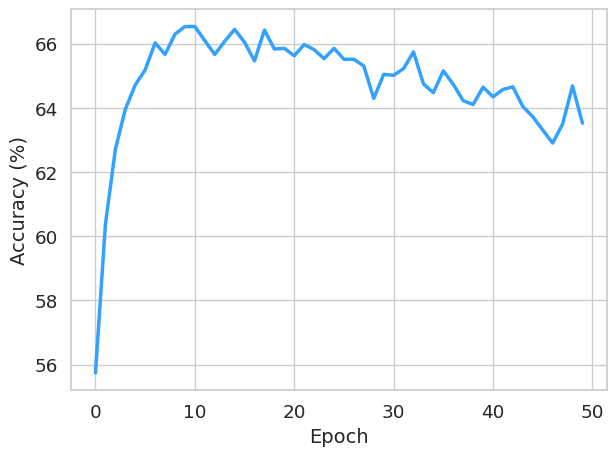

In [10]:
sns.set_theme(style="whitegrid", font_scale=1.2)
custom_colors = ['#33A2FF']
sns.set_palette(custom_colors)
sns.lineplot(x=list(range(len(test_accuracies))), y=test_accuracies, linewidth=2.5)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.tight_layout()
plt.savefig("figures/accuracy_over_gaussian.png")
plt.show()

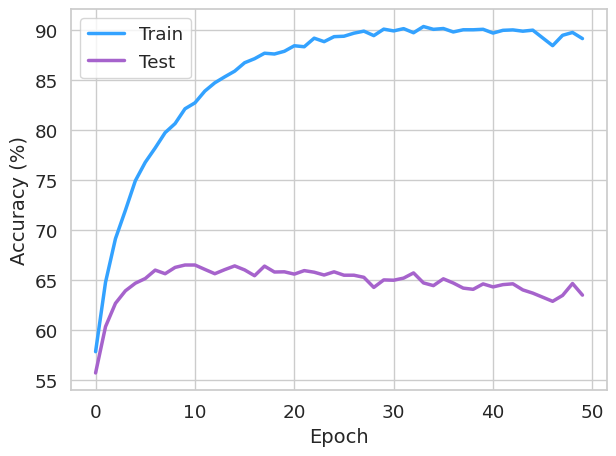

In [ ]:
sns.set_theme(style="whitegrid", font_scale=1.2)
custom_colors = ['#33A2FF', '#a663cc']
sns.set_palette(custom_colors)
sns.lineplot(x=list(range(len(train_accuracies))), y=train_accuracies, label='Train', linewidth=2.5)
sns.lineplot(x=list(range(len(test_accuracies))), y=test_accuracies, label='Test', linewidth=2.5)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.tight_layout()
plt.savefig("figures/test_train_accuracy.png")
plt.show()

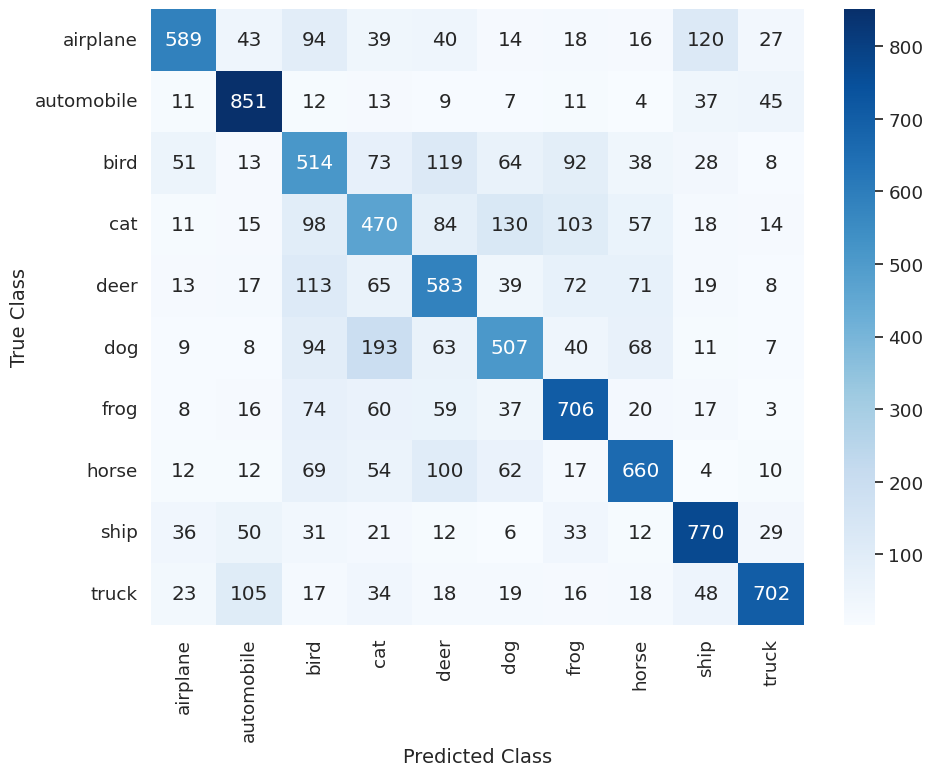

In [12]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = tm.predict(graphs_test)

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.set_theme(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.ylabel('True Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.tight_layout()
plt.savefig("figures/confusion_matrix_gaussian.png")
plt.show()